In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


llms = [ 
    "gemma3n",  
    "qwen2.5",  
    "llama3.1",  
    "orca2",  
]


examples = {
    "FIC" : "join_examples_dict_1", 
    "CIC" : 'join_examples_dict_2',
    "FSC" : 'vector_based_examples_dict_1',
    "CSC" : 'vector_based_examples_dict_2',
}

model_types = ['TF', 'FT', 'UN', 'IN']


def extract_model_type(model, suffix=""): 
    flag = True
    for ll in llms:
        if ll in model:
            flag = False
    if flag: 
        return "P1"
    elif ' U ' in model: 
        return f"UN{suffix}"
    elif ' ∩ ' in model: 
        return f"IN{suffix}"
    elif '-tf-p2' in model: 
        return "TF"
    elif '-ft-p2' in model: 
        return "FT"
    elif '-z-p2' in model: 
        return "ZS" 
    else: 
        return "P1"


def df_plot_show(groups, datasets): 
    prompt_types = list(groups.keys())
    average_f1 = np.array(list(groups.values()))

    bar_width = 0.2                   # width of each bar
    group_spacing = 0.5  # extra space between groups

    group_width = len(datasets) * bar_width + group_spacing
    x = np.arange(len(prompt_types)) * group_width

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, dataset in enumerate(datasets):
        ax.bar(x + i*bar_width, average_f1[:, i], width=bar_width, label=dataset)
        
    # Labels and styling
    ax.set_xlabel("Prompt Type", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)
    ax.set_title("Average F1 Score per Prompt Type and Dataset (Standard Blocking)", fontsize=14)
    ax.set_xticks(x + bar_width*(len(datasets)-1)/2)
    ax.set_xticklabels(prompt_types)
    ax.legend(title="Datasets")

    
    plt.tight_layout()

    plt.show()
    




In [4]:
def results_extraction_main(candidate_pairs): 
    
    groups = {"ZS" : []}    
        
    datasets = ['D2', 'D5', 'D6', 'D7', 'D8']
    for dataset in datasets:
        
        results = f'../results/{candidate_pairs}/{dataset}_clustering.csv'
        results = pd.read_csv(results)
    
        results_ui = f'../results/{candidate_pairs}/{dataset}_ui.csv'
        results_ui = pd.read_csv(results_ui)
    
        cols = ["precision","recall","f1"]
    
        for col in cols: 
            results_ui[col] = results_ui[col] * 100
    
        results_ui['model_type'] = results_ui['model'].apply(lambda x: extract_model_type(x, ""))
        results['model_type'] = results['model'].apply(lambda x: extract_model_type(x, ''))

        results = results[(results['model_type'] != 'P1') & (results['model_type'] != 'UN') & (results['model_type'] != 'IN')]  
        result_ui = results_ui[(results_ui['model_type'] != 'P1')]
        
        results = pd.concat([results, result_ui])  

        groupby = results.groupby(by=['model_type', 'examples'])


        groups["ZS"].append(groupby.get_group(("ZS", "vector_based_examples_dict_1"))['f1'].mean())


        for model in model_types: 
            for key in examples: 
                if f'{key}-{model}' not in groups: 
                    groups[f'{key}-{model}'] = [groupby.get_group((model, examples[key]))['f1'].mean()]
                else:
                    groups[f'{key}-{model}'].append(groupby.get_group((model, examples[key]))['f1'].mean())
           

    # groups
    df_plot_show(groups, datasets)


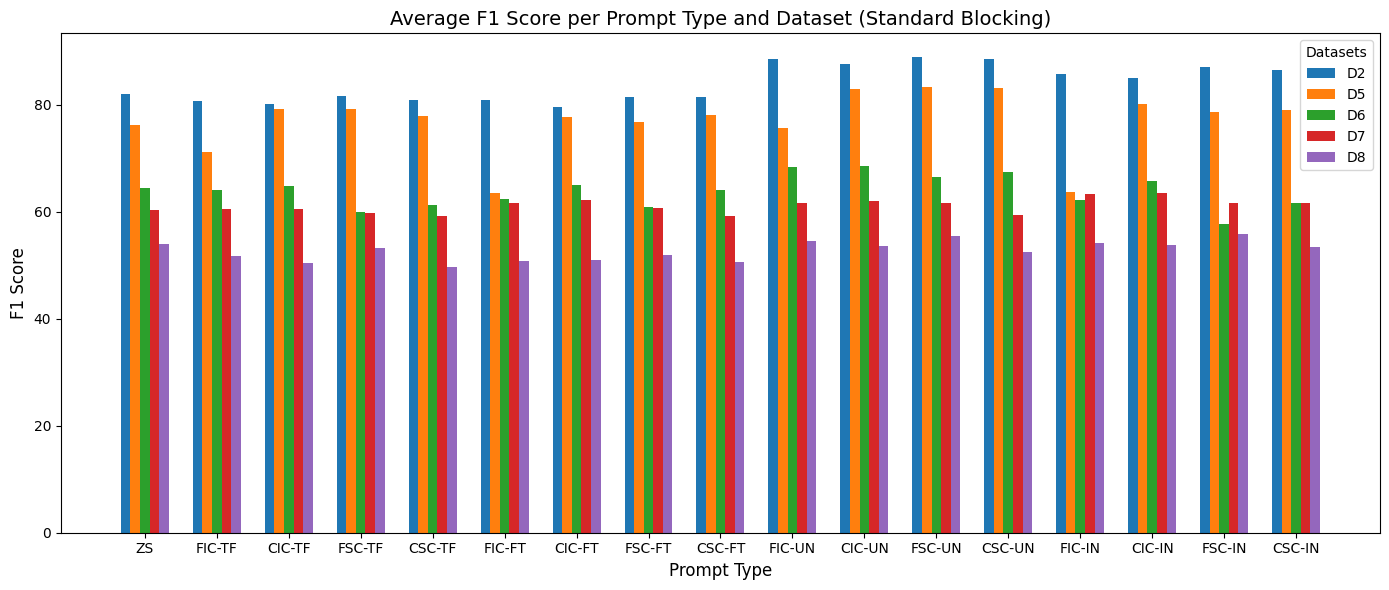

In [5]:

candidate_pairs = 'standard_blocking'
results_extraction_main(candidate_pairs)
